#### WAICUP V2 Test

In [49]:
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank, Cauchy, Morlet
from magprime import utility
import matplotlib.pyplot as plt
import numpy as np
import itertools

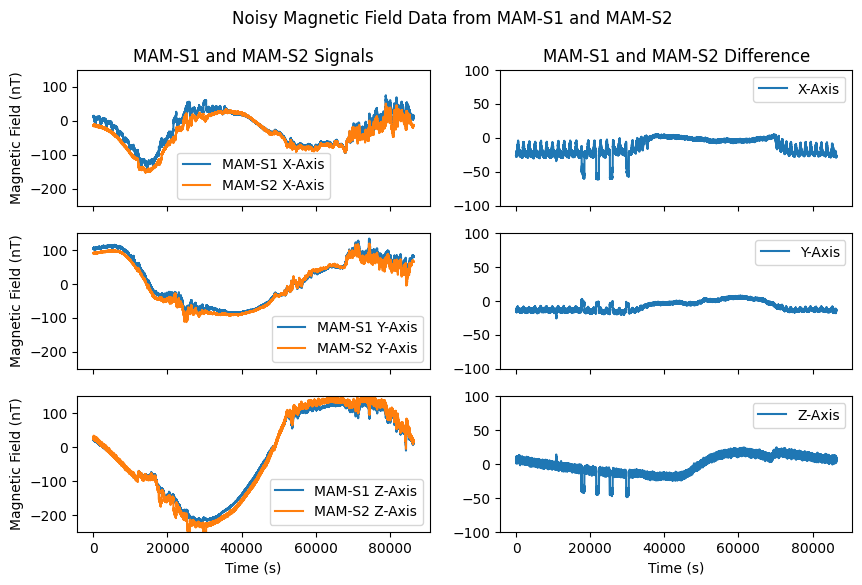

In [16]:
"Load raw data with offsets"
B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)
sample_rate = 1.0 # Hz



"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()

In [91]:
fb = DyadicFilterBank(wavelet=Morlet(1,10) , fs=sample_rate, N=2*86400, real=True, dj = 1/2, s_max=100)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
)

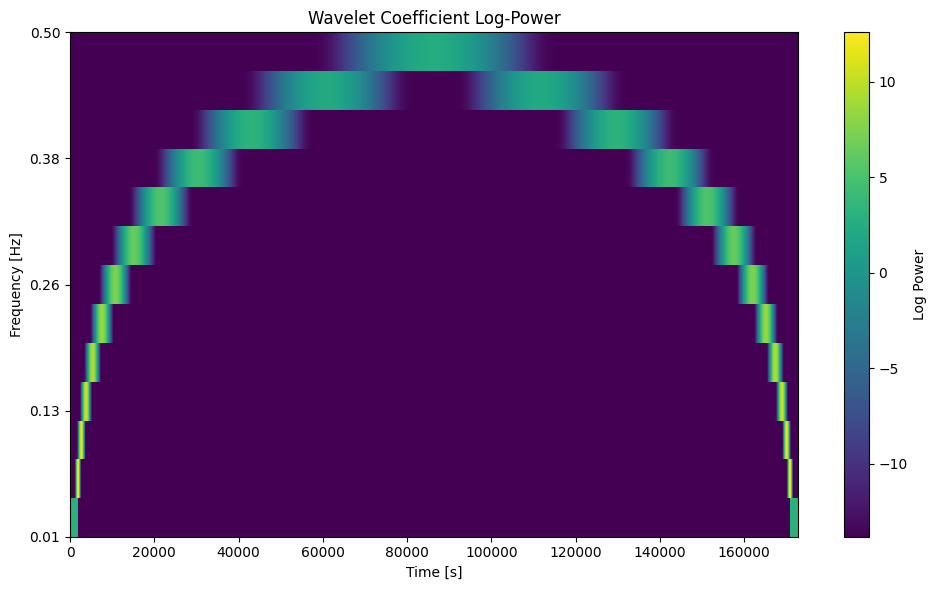

In [92]:
transform.scalogram(np.abs(transform.Wfreq)+1e-3)

In [93]:
def dual(B):
    "Calculate Wavelet Coefficients"
    w1 = transform.forward(B[0], mode='same')  # shape (J, T), complex
    w2 = transform.forward(B[1], mode='same')  # shape (J, T), complex


    D = w2 - w1  # shape (J, T), complex

    # 1) correlations (eqs 6–7), using conjugate inner products
    C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
    C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

    # 2) gain estimate K̂ per scale (eq 8)
    K_hat = C2 / C1                          # shape (J,)

    # 3) ambient‑field estimate X(s,τ) (eq 10)
    X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

    amb_mf = transform.inverse(X)  # shape (T, n_sensor, n_axis), complex
    return amb_mf

def multi(B):
    "Find Combinations"
    pair_indices = list(itertools.combinations(range(B.shape[0]), 2))
    X_list = []

    # Step 1: WAICUP in the filterbank / wavelet domain
    for i, j in pair_indices:
        w1 = transform.forward(B[i], mode='full')   # → (J, T), complex
        w2 = transform.forward(B[j], mode='full')   # → (J, T), complex

        D   = w2 - w1                               # (J, T)
        C1  = np.sum(D * np.conj(w1), axis=1)       # (J,)
        C2  = np.sum(D * np.conj(w2), axis=1)       # (J,)
        K   = C2 / C1                               # (J,)

        # ambient-wavelet estimate X(s,τ)  eq(10)
        Xij = (K[:,None]*w1 - w2) / (K[:,None] - 1) # (J, T)
        X_list.append(Xij)

    # Step 2: pick the minimum‐magnitude X across all pairs
    X_stack = np.stack(X_list, axis=0)              # (n_pairs, J, T)
    abs_X   = np.abs(X_stack)                       # (n_pairs, J, T)
    winner  = np.argmin(abs_X, axis=0)              # (J, T)

    # fancy‐indexing to grab the winning X(s,τ) at each scale/time
    J, T = winner.shape
    jj, tt = np.indices((J, T))
    X_sel = X_stack[winner, jj, tt]                 # (J, T)

    # Step 3: one inverse transform back to the time series
    ambient = transform.inverse(X_sel)
    return ambient  

In [94]:
Bx = dual(B[:,0])

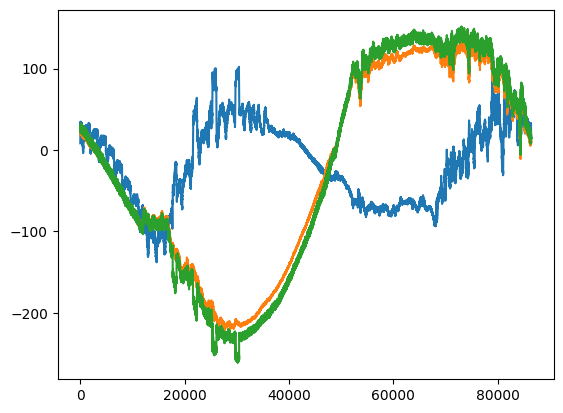

In [95]:
plt.plot(Bx)
plt.plot(B[:,2].T)